Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [33]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, Flatten, Dense, Dropout, Rescaling
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
#from tensorflow.keras.utils import to_categorical

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [34]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [37]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

root_path = '/content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [38]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
##todo
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
##todo
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [40]:
# making test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [39]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

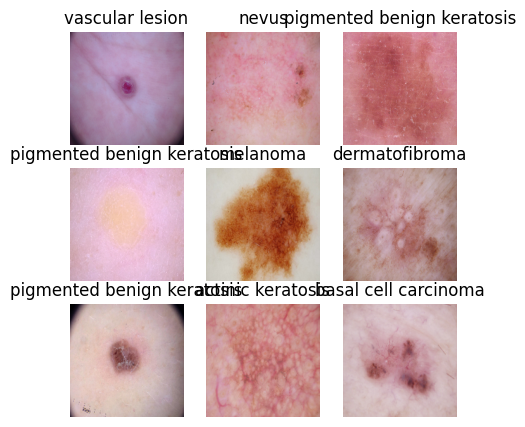

In [42]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [7]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=9)  # 9 classes
    return image, label

In [ ]:
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
input_shape = (180,180,3)

In [ ]:
### Your code goes here

model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
optimizer = 'adam'
loss_fn = "categorical_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 129600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │      16,588,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,609,481 (63.36 MB)

 Trainable params: 16,609,481 (63.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.2008 - loss: 3.3515 - val_accuracy: 0.3199 - val_loss: 1.9771
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.2852 - loss: 1.8911 - val_accuracy: 0.4743 - val_loss: 1.6988
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4861 - loss: 1.5192 - val_accuracy: 0.5190 - val_loss: 1.5013
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5373 - loss: 1.3351 - val_accuracy: 0.5302 - val_loss: 1.4306
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5834 - loss: 1.1902 - val_accuracy: 0.5190 - val_loss: 1.5259
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6239 - loss: 1.0657 - val_accuracy: 0.5145 - val_loss: 1.5587
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6754 - loss: 0.9590 - val_accuracy: 0.5190 - val_loss: 1.5079
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6940 - loss: 0.8891 - val_accuracy: 0.5257 - v

### Visualizing training results

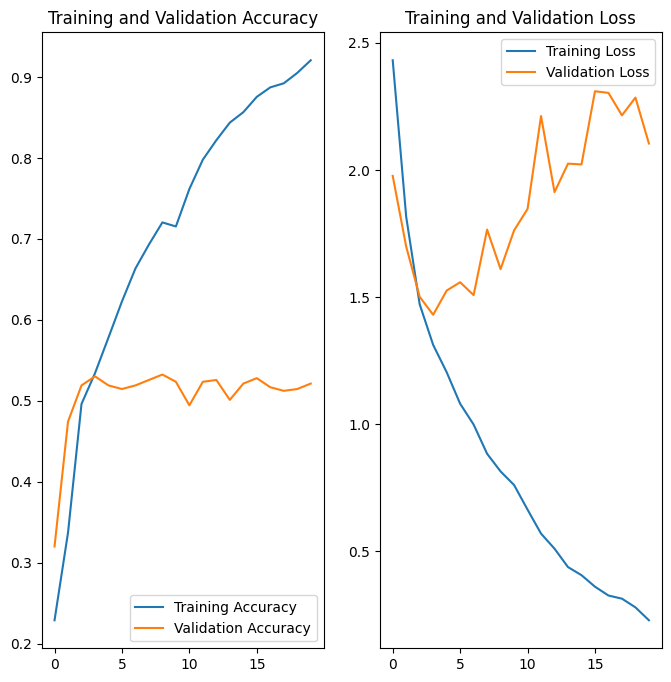

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

The model's training accuracy shows a steady increase of upto 93%, while validation accuracy remains consistently around 52%.This indicates overfitting where the model has captured noise in train data, but cannot generalize on test data. Difference is 41%. To address overfitting, augmentation techniques will be employed. Given the limited training data available, new samples will be generated by making slight modifications to existing data (such as horizontal/vertical image flipping, minor image rotations, etc.), which will then be used for training the model. Also, dropout layers will be used.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

augmentation_data = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = tf.keras.models.Sequential([
    augmentation_data,
    tf.keras.layers.Rescaling(1./255,input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])

### Compiling the model

In [ ]:
## Your code goes here

optimizer = "adam"
loss_fn = "categorical_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.1908 - loss: 4.6532 - val_accuracy: 0.3647 - val_loss: 1.7622
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.3412 - loss: 1.8346 - val_accuracy: 0.4564 - val_loss: 1.6157
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.4147 - loss: 1.6580 - val_accuracy: 0.5078 - val_loss: 1.4369
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4780 - loss: 1.4917 - val_accuracy: 0.5347 - val_loss: 1.4420
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.5374 - loss: 1.3551 - val_accuracy: 0.5302 - val_loss: 1.4366
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5227 - loss: 1.3576 - val_accuracy: 0.5190 - val_loss: 1.4066
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.5324 - loss: 1.3234 - val_accuracy: 0.5503 - val_loss: 1.3755
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.5543 - loss: 1.2974 - val_accuracy: 0.5324 - v

### Visualizing the results

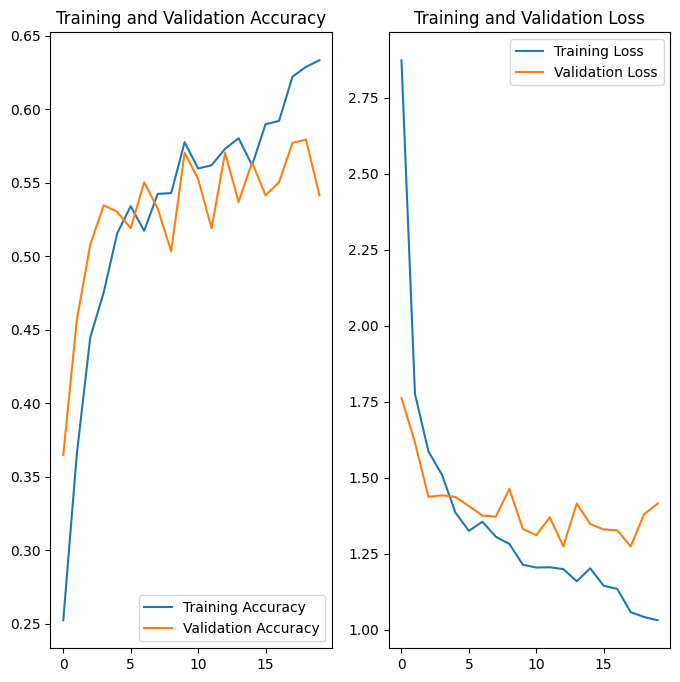

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

With augmented data layers and dropout layer, overfitting has been effectively addressed. The training and validation accuracy nearly fall within a similar range. Both the training and validation data are showing poor performance, indicating that the model is now exhibiting underfitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [ ]:
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000081.jpg', 'nevus'), ('/content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000079.jpg', 'nevus'), ('/content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000083.jpg', 'nevus'), ('/content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000050.jpg', 'nevus'), ('/content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000060.jpg', 'nevus')]


In [ ]:
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assig...,nevus
1,/content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assig...,nevus
2,/content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assig...,nevus
3,/content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assig...,nevus
4,/content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assig...,nevus


In [ ]:
lesions_df[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


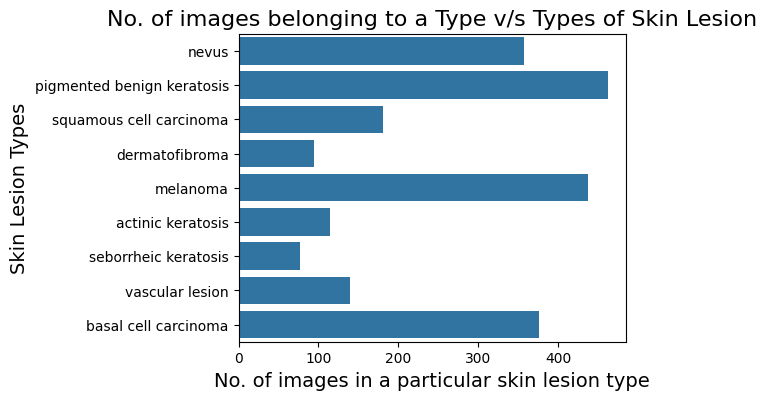

In [ ]:
import seaborn as sns

plt.figure(figsize=(5, 4))
sns.countplot(y="Label", data=lesions_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

The class **"seborrheic keratosis"** comprises the smallest proportion of samples

**"Pigmented benign keratosis"** and **"melanoma"** significantly outweigh other classes

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [ ]:
path_to_training_dataset='/content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse, saving the same in directory.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D42656D8690>: 100%|██████████| 500/500 [00:18<00:00, 26.72 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D4264D4E3D0>: 100%|██████████| 500/500 [00:16<00:00, 29.89 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D43A6E7D190>: 100%|██████████| 500/500 [00:19<00:00, 25.43 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D426507AE10>: 100%|██████████| 500/500 [01:19<00:00,  6.25 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x641 at 0x7D42657C6E90>: 100%|██████████| 500/500 [01:19<00:00,  6.27 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D42657DB910>: 100%|██████████| 500/500 [00:16<00:00, 29.56 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D4264A7D150>: 100%|██████████| 500/500 [00:38<00:00, 13.00 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D4264D2BCD0>: 100%|██████████| 500/500 [00:16<00:00, 29.54 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D4264B570D0>: 100%|██████████| 500/500 [00:18<00:00, 27.65 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027829.jpg_70632a41-6278-4837-a63a-6eea64f9fe96.jpg',
 '/content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000055.jpg_0a4e2140-7fa9-4d2b-bd7e-dcc3e28cced3.jpg',
 '/content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000343.jpg_119895bd-629f-4433-98cd-4dd464c62397.jpg',
 '/content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000362.jpg_af23c172-0b67-412c-9c7e-57303dd94476.jpg',
 '/content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_00249

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

(6739, 2)

In [ ]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [8]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [9]:
root_path = '/content/gdrive/MyDrive/Upgrad_AI_ML/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(root_path + '/Train')

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


#### **Todo:** Create a validation dataset

In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


Encoding

In [13]:
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
model = tf.keras.models.Sequential([
    augmentation_data,
    tf.keras.layers.Rescaling(1./255,input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])


model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 129600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │      16,588,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,609,737 (63.36 MB)

 Trainable params: 16,609,609 (63.36 MB)

 Non-trainable params: 128 (512.00 B)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 234ms/step - accuracy: 0.2751 - loss: 4.7296 - val_accuracy: 0.3118 - val_loss: 2.0084
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 232ms/step - accuracy: 0.3997 - loss: 1.5744 - val_accuracy: 0.3890 - val_loss: 1.7940
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - accuracy: 0.4331 - loss: 1.4727 - val_accuracy: 0.3875 - val_loss: 1.6235
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 236ms/step - accuracy: 0.4733 - loss: 1.3990 - val_accuracy: 0.4113 - val_loss: 1.6700
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 244ms/step - accuracy: 0.4677 - loss: 1.3738 - val_accuracy: 0.2494 - val_loss: 2.1448
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 228ms/step - accuracy: 0.4796 - loss: 1.3690 - val_accuracy: 0.3964 - val_loss: 1.9540
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 244ms/step - accuracy: 0.5114 - loss: 1.2756 - val_accuracy: 0.5004 - val_loss: 1.3860
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 240ms/step - accuracy: 0.5312 - loss: 1

#### **Todo:**  Visualize the model results

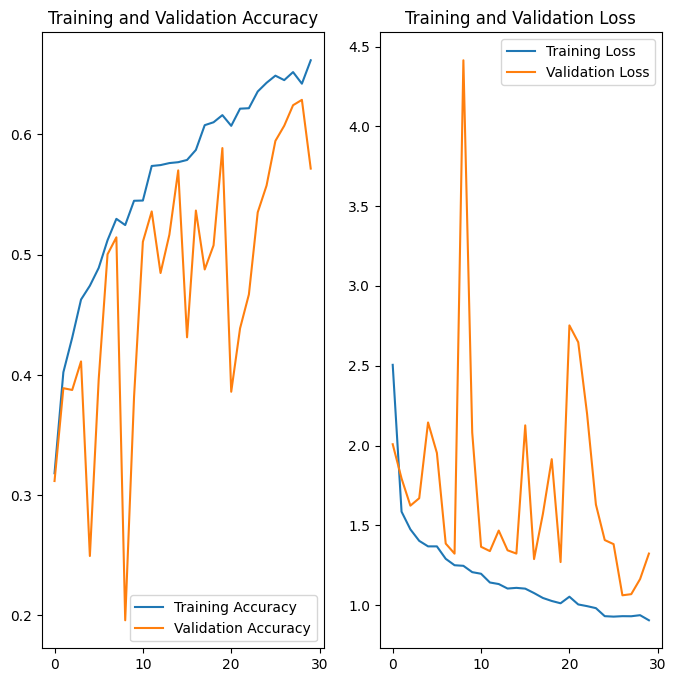

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Overfitting is reduced greatly. But there is scope of increasing accuracy.

Trying a model without batch normalization

## Model Without Batch Normalization

### Model Creation

In [22]:
model = tf.keras.models.Sequential([
    augmentation_data,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])


model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 129600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      16,588,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,609,481 (63.36 MB)

 Trainable params: 16,609,481 (63.36 MB)

 Non-trainable params: 0 (0.00 B)

### Model Compilation

In [23]:


model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])

In [24]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.1576 - loss: 3.5379 - val_accuracy: 0.2772 - val_loss: 1.7756
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.3230 - loss: 1.7373 - val_accuracy: 0.4010 - val_loss: 1.5708
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.4212 - loss: 1.5231 - val_accuracy: 0.4529 - val_loss: 1.3933
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.4530 - loss: 1.4413 - val_accuracy: 0.4692 - val_loss: 1.4320
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.4916 - loss: 1.3429 - val_accuracy: 0.5115 - val_loss: 1.2902
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.4877 - loss: 1.3208 - val_accuracy: 0.5196 - val_loss: 1.3641
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.5341 - loss: 1.2640 - val_accuracy: 0.5597 - val_loss: 1.1926
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.5490 - loss: 1.2062 - 

### Visualizing results

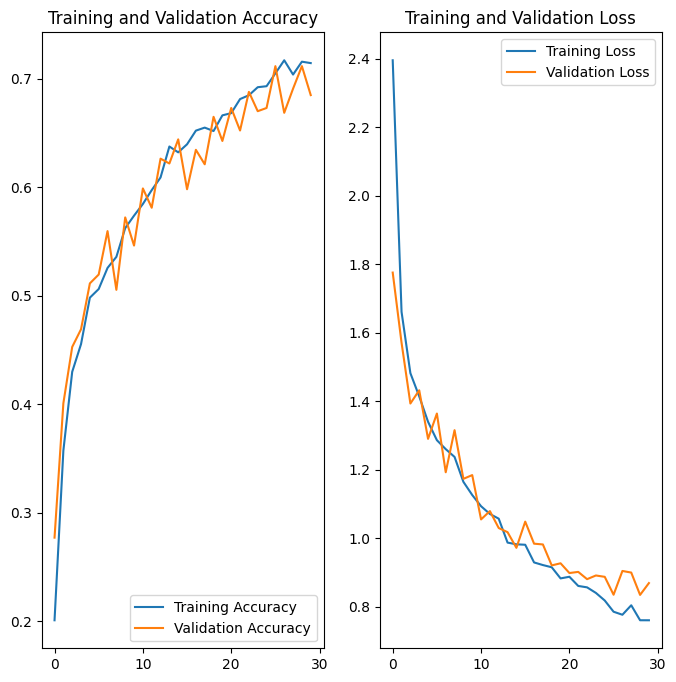

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

1. The ultimate model displayed well-balanced performance, displaying no signs of underfitting or overfitting.

2. Following 30 epochs, the final model attains a train accuracy of 73% and validation accuracy of 68%.

3. The implementation of class rebalancing has notably enhanced the model's performance across both training and validation datasets.